Run Twirler before this piece of code

In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_16_melbourne')
two_error_map =  get_cx_error_map(machine)

#noise model
noise_model = NoiseModel.from_backend(machine)

# Twirler

In [4]:
import re #because we need regular expressions
import numpy as np #because we need the random number generator
from qiskit import *
from qiskit.tools.monitor import job_monitor

import sys
sys.path.append('../')

from qiskit.aqua.utils import *

import numpy as np

Pauligateset=['id','x','y','z']

def equal(A, B, tolerance=1E-6, allowPhaseCheck=True):
    """
    Returns True if A and B are equal within tolerance tol, element-wise
    :param A: nxm matrix
    :param B: nxm matrix
    :param tolerance: Tolerance
    :param allowPhaseCheck: True if A and B should be considered equal if they are equal up to a complex phase factor
    :raises ValueError: if A, B not correct shape
    :return: True or False
    """
    dim0 = A.shape[0]
    dim1 = A.shape[1]
    if len(A.shape) > 2 or len(B.shape) > 2:
        raise ValueError("Both arguments must be n x m matrices.")
    if dim0 != B.shape[0] or dim1 != B.shape[1]:
        raise ValueError("Arguments must be of equal dimension.")

    checkPhase = False

    for ind in range(dim0):
        if checkPhase:
            break
        for j in range(dim1):
            num = np.absolute(A[ind, j] - B[ind, j])
            if num > tolerance:
                if allowPhaseCheck:
                    checkPhase = True  # There might be a (global) phase difference between the matrices
                else:
                    return False
                break

    if checkPhase:# Handle the case A = e^(i * theta) * B
        first = True
        eiPhase = 1

        for ind in range(dim0):
            for j in range(dim1):
                A_ij = A[ind, j]
                B_ij = B[ind, j]

                if np.absolute(A_ij) < tolerance:
                    A_ij = 0
                if np.absolute(B_ij) < tolerance:
                    B_ij = 0

                if A_ij == 0 and B_ij == 0:
                    continue
                elif (A_ij == 0 and B_ij != 0) or (A_ij != 0 and B_ij == 0):
                    # If one is zero, multiplying by phase factor does not change anything.
                    # Therefore, the other must be zero for the matrices to be equal up to a phase factor.
                    return False

                rel = A_ij / B_ij
                if np.absolute(np.absolute(rel) - 1) > tolerance:  # a/b must be 1.000... * e^(i * theta)
                    return False
                if first:
                    first = False
                    eiPhase = rel  # e ^(i * theta)
                if np.absolute(eiPhase - rel) > tolerance:
                    return False
    return True

def getPaulitwirlingPairsCX(printpairs=False):
    
    #making the gates
    
    ID1q = np.array([[1, 0], [0, 1]], dtype=np.complex_)
    sigmaX = np.array([[0, 1], [1, 0]], dtype=np.complex_)
    sigmaY = np.array([[0, 0 - 1.0j], [0 + 1.0j, 0]], dtype=np.complex_)
    sigmaZ = np.array([[1, 0], [0, -1]], dtype=np.complex_)

    ID2q = np.kron(ID1q, ID1q)

    tol = 1E-8

    paulis = np.array([ID1q, sigmaX, sigmaY, sigmaZ], dtype=np.complex_)

    cX = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=np.complex_)
    
    #some kind of new array

    pairs = np.zeros((4, 4, 2), dtype=int)
    
    #making all possible configurations for twirling (gates a,b,c,d)

    for a in range(4):  # sigma_control ^a
        pauli_ca = paulis[a]
        for b in range(4):  # sigma_target ^b
            pauli_tb = paulis[b]
            for c in range(4):  # sigma_control ^c
                pauli_cc = paulis[c]
                for d in range(4):  # sigma_target ^d
                    pauli_td = paulis[d]
                    LHS = np.kron(pauli_cc, pauli_td)
                    RHS = cX @ np.kron(pauli_ca, pauli_tb) @ cX.transpose().conjugate()
                    if equal(LHS, RHS, tol):
                        if printpairs:
                            print(Pauligateset[a],Pauligateset[b],Pauligateset[c],Pauligateset[d])
                        pairs[a][b][0] = c
                        pairs[a][b][1] = d
    return pairs

twirlingPairs = getPaulitwirlingPairsCX()

def create_Paulitwirled_and_noiseamplified_circuit(circuit,r,two_error_map,paulitwirling=True,controlledgatename='cx'):
    '''Pauli-twirl and amplify noise of controlled gates in a circuit
    Args:
        circuit: the original circuit
        r: noise amplification factor
        two_error_map: map of error rates of controlled gate between two qubits
        paulitwirling: turn Pauli-twirling on or off
        controlledgatename: name of the controlled gate to apply Pauli-twirling and error amplification to
    Returns:
        new circuit that is Pauli-twirled and errors are amplified by a factor for r
    '''
    newqasm_str=""
    qs=circuit.qasm()
    qregname=circuit.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith(controlledgatename):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1
            ## Apply Pauli-twirling
            if paulitwirling:
                indices_ab = np.random.randint(0, 4, 2)
                indices_cd = twirlingPairs[indices_ab[0]][indices_ab[1]]

                if indices_ab[0]>0:
                    newqasm_str+=Pauligateset[indices_ab[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_ab[1]>0:
                    newqasm_str+=Pauligateset[indices_ab[1]]+" "+qregname+"["+str(target_ind)+"];\n"
                    
                newqasm_str+=line+"\n"
                
                if indices_cd[0]>0:
                    newqasm_str+=Pauligateset[indices_cd[0]]+" "+qregname+"["+str(control_ind)+"];\n"
                if indices_cd[1]>0:
                    newqasm_str+=Pauligateset[indices_cd[1]]+" "+qregname+"["+str(target_ind)+"];\n"
            else:
                newqasm_str+=line+"\n"

            ## increase the error rate of a cx gate
            if np.random.uniform(0, 1) < (r - 1) * two_error_map[control_ind][target_ind]:
                ### we need to avoid that the indentity is drawn for the control and the target qubit at the same time
                ### there are 4x4 combinations
                # I I    X I    Y I    Z I
                # I X    X X    Y X    Z X
                # I Y    X Y    Y Y    Z Y
                # I Z    X Z    Y Z    Z Z
                # with global indexation for random numbers
                # 0      4      8      12
                # 1      5      9      13
                # 2      6      10     14
                # 3      7      11     15
                # and local indexation
                # 0,0    1,0    2,0    3,0
                # 0,1    1,1    2,1    3,1
                # 0,2    1,2    2,2    3,2
                # 0,3    1,3    2,3    3,3
                # so we make sure to never draw 0 = (0,0) = I I
                ind_ef = np.random.randint(1, 16, 1)
                ind_e=int(int(ind_ef[0])/4)
                ind_f=ind_ef[0]%4
                if ind_e>0:
                    newqasm_str+=Pauligateset[ind_e]+" "+qregname+"["+str(control_ind)+"];\n"
                if ind_f>0:
                    newqasm_str+=Pauligateset[ind_f]+" "+qregname+"["+str(target_ind)+"];\n"

        else:
            newqasm_str+=line+"\n"
    circ=QuantumCircuit().from_qasm_str(newqasm_str)
    return circ

def Richardson_extrapolate(E, c):
    n=E.shape[0]
    if c.shape[0] != n:
        raise ValueError('E and c must have the same dimension.')
    if n<=1:
        raise ValueError('the dimension of E and c must be larger than 1.')
    A = np.zeros((n,n))
    b = np.zeros((n,1))
    #must sum to 1
    A[0,:] = 1
    b[0] = 1
    for k in range(1,n):
        A[k,:] = c**k
    x=np.linalg.solve(A,b)
    return np.dot(np.transpose(E),x)

def mitigate(circuit, amplification_factors,\
             expectationvalue_fun,\
             execution_backend, \
             experimentname, cx_error_map,\
             num_shots, num_experiments,\
             target_backend=None, noise_model=None, basis_gates=None,\
             paulitwirling=True, verbose=True):
    """
    it is of utter most importance, that the circit is executable on the backend that it is to be executed/targeted for
    target_backend: is used if execution_backend is a simulator
    noisemodel: is used if execution_backend is a simulator
    this function is implemented with convenience in mind, the classical part can be trivially made more memory efficient
    """
    optimization_level=1

    n_qubits = execution_backend.configuration().n_qubits
    is_simulator = execution_backend.configuration().simulator

    max_depth_dict={}
    mean_depth_dict={}
    max_depth_transpiled_dict={}
    mean_depth_transpiled_dict={}
    jobs_dict={}
    E_dict={}
    E_av_dict={}
    result_dict={}

    ### sanity checks
    if len(amplification_factors)<2:
        raise ValueError("specify at least 2 amplification factors, e.g., (1,2) ")
    if is_simulator:
        if target_backend == None:
            raise ValueError("you need to specify a taget backend")
        if noise_model == None:
            raise ValueError("you need to specify a noise model")
        if basis_gates == None:
            raise ValueError("you need to specify basis gates")
    else:
        execution_backend = target_backend

    if verbose:
        print("Sanity checks passed")

    if is_simulator:
        # in the case of a simulator,
        # we do not need to split the runs,
        # because max_experiments is not limited
        experimentname+="_backend"+execution_backend.name()
        experimentname+="_noisemodel"+target_backend.name()
        experimentname+="_shots"+str(num_shots)
        experimentname+="_experiments"+str(num_experiments)
        experimentname+="_paulitwirling"+str(paulitwirling)
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            result_dict[name] = read_results(name)
            if verbose:
                if result_dict[name] == None:
                    print("Could not read result for job '",name, "' from disk")
                else:
                    print("Result for job '",name, "' successfully read from disk")

            ### read circuit depth statistics from file
            if not result_dict[name] == None:
                with open('results/'+name+'.mean_circuit_depth','r') as f:
                    mean_depth_dict[name]=float(f.read())
                with open('results/'+name+'.max_circuit_depth','r') as f:
                    max_depth_dict[name]=float(f.read())
                with open('results/'+name+'.mean_transpiled_circuit_depth','r') as f:
                    mean_depth_transpiled_dict[name]=float(f.read())
                with open('results/'+name+'.max_transpiled_circuit_depth','r') as f:
                    max_depth_transpiled_dict[name]=float(f.read())

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            mean_depth=0
            max_depth=0
            mean_depth_transpiled=0
            max_depth_transpiled=0
            circuits_r=[]
            for p in range(1,num_experiments+1):
                if verbose and p%25==0:
                    print("Creating circuits for '",name, "'", p, "/",num_experiments, end='\r')
                circ_tmp = create_Paulitwirled_and_noiseamplified_circuit(\
                                    circuit, r, cx_error_map, paulitwirling)
                depth = circ_tmp.depth()
                mean_depth += depth
                max_depth = max(max_depth,depth)
                # now we can transpile to combine single qubit gates, etc.
                circ_tmp_transpiled=transpile(circ_tmp,\
                                              backend=target_backend,\
                                              optimization_level=optimization_level)
                circuits_r.append(circ_tmp_transpiled)
                depth=circ_tmp_transpiled.depth()
                mean_depth_transpiled += depth
                max_depth_transpiled = max(max_depth_transpiled,depth)
            if verbose:
                print("Creating circuits for '",name, "'", num_experiments, "/",num_experiments)
            max_depth_dict[name]=max_depth
            mean_depth_dict[name]=mean_depth/num_experiments
            max_depth_transpiled_dict[name]=max_depth_transpiled
            mean_depth_transpiled_dict[name]=mean_depth_transpiled/num_experiments
            if verbose:
                print("Starting job for '",name, "'")
            jobs_dict[name] = execute(circuits_r,\
                            execution_backend,\
                            noise_model=noise_model,\
                            basis_gates=basis_gates,\
                            shots=num_shots)

        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if not result_dict[name] == None:
                continue
            job_monitor(jobs_dict[name])
            success = write_results(name,jobs_dict[name])
            if verbose:
                if success:
                    print("Result for job '",name, "' successfully written to disk")
                else:
                    print("Could not write result for job '",name, "' from disk")

            ### write circuit depth statistics to file
            with open('results/'+name+'.mean_circuit_depth','w') as f:
                f.write(str(mean_depth_dict[name]))
            with open('results/'+name+'.max_circuit_depth','w') as f:
                f.write(str(max_depth_dict[name]))
            with open('results/'+name+'.mean_transpiled_circuit_depth','w') as f:
                f.write(str(mean_depth_transpiled_dict[name]))
            with open('results/'+name+'.max_transpiled_circuit_depth','w') as f:
                f.write(str(max_depth_transpiled_dict[name]))

        first=True
        for r in amplification_factors:
            name=experimentname+"_r"+str(r)
            if result_dict[name] == None:
                result_dict[name] = read_results(name)
            E_dict[name] = expectationvalue_fun(result_dict[name])
            E_av_dict[name] = np.zeros_like(E_dict[name])
            for j in range(1,num_experiments+1):
                E_av_dict[name][j-1] = sum(E_dict[name][0:j])/j
            if first:
                E_av=E_av_dict[name]
                first=False
            else:
                E_av=np.append(E_av,E_av_dict[name])## this is not very efficient coding

    else:
        raise ValueError("not yet implemented, coming soon")

    R=Richardson_extrapolate(E_av.reshape(len(amplification_factors),num_experiments),\
                             np.array(amplification_factors))


    return R, E_dict, E_av_dict,\
           max_depth_dict,mean_depth_dict,\
           max_depth_transpiled_dict,mean_depth_transpiled_dict,\
           experimentname
import numpy as np
import os
import datetime
import time
import pickle
from qiskit import *
from qiskit.providers.jobstatus import JOB_FINAL_STATES, JobStatus

def start_or_retrieve_job(filename, backend, circuit=None, options=None):
    """function that
       1) retrieves the job from the backend if saved to file,
       2) or executes a job on a backend and saves it to file
    Parameters
    ----------
    filename : string
        The filename to write/read from. The extension ".job" is
        automatically appended to the string.
    backend : qiskit.providers.ibmq.ibmqbackend.IBMQBackend
        The backend where the job has been/is to be executed.
    circuit : qiskit.circuit.quantumcircuit.QuantumCircuit, optional
        The circuit that is to be executed.
    options: dict, optional
        The following is a list of all options and their default value
        options={'shots': 1024, 'forcererun': False, 'useapitoken': False, 'directory': 'jobs'}
        the directory is created if it does not exist
    Returns
    -------
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        
    """
    ### options parsing
    if options == None:
        options={}
    shots = options.get('shots', 1024)
    forcererun = options.get('forcererun', False)
    useapitoken = options.get('useapitoken', False)
    directory = options.get('directory', 'jobs')

    filename = filename+'.job'
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not(forcererun) and os.path.isfile(directory+'/'+filename):
        #read job id from file and retrieve the job
        with open(directory+'/'+filename, 'r') as f:
            apitoken = f.readline().rstrip()
            backendname = f.readline().rstrip()
            job_id = f.readline().rstrip()
        if useapitoken:
            IBMQ.save_account(apitoken, overwrite=True)
            IBMQ.load_account()
            provider = IBMQ.get_provider(hub='ibm-q')
            backend_tmp = provider.get_backend(backendname)
            if backend.name() != backend_tmp.name():
                raise Exception("The backend of the job was "+backend_tmp.name()+", but you requested "+backend.name())
            job = backend_tmp.retrieve_job(job_id)
        else:
            job = backend.retrieve_job(job_id)
    else:
        # otherwise start the job and write the id to file
        hasnotrun = True
        while hasnotrun:
            error = False
            try:
                job = execute(circuit, backend, shots=int(shots))
            except Exception as e:
                error = True
                sec  = 60
                if "Error code: 3458" in str(e):
                    print(filename +' No credits available, retry in '+str(sec)+' seconds'+', time='+str(datetime.datetime.now()), end='\r')
                else:
                    print('{j} Error! Code: {c}, Message: {m}, Time {t}'.format(j=str(filename), c = type(e).__name__, m = str(e), t=str(datetime.datetime.now())), ", retry in ",str(sec),' seconds', end='\r')
                time.sleep(sec)
            if not(error):
                hasnotrun = False
        job_id = job.job_id()
        apitoken = IBMQ.active_account()['token']
        backendname = backend.name()
        if job_id != '':
            file = open(directory+'/'+filename,'w')
            file.write(apitoken+'\n')
            file.write(backendname+'\n')
            file.write(job_id)
            file.close()
    return job

def write_results(filename, job, options=None):
    """function that writes the results of a job to file
    Parameters
    ----------
    filename : string
        The filename to write to. The extension ".result" is
        automatically appended to the string.
    job : qiskit.providers.ibmq.job.ibmqjob.IBMQJob,
          qiskit.providers.aer.aerjob.AerJob
        The job to get the results from
    options: dict, optional
        The following is a list of all options and their default value
        options={'overwrite': False, 'directory': 'results'}
    Returns
    -------
    success : bool
        set to True if the results from the job are written to file
        it is set to False, e.g., if the job has not yet finished successfully
    """
    ### options parsing
    if options == None:
        options={}
    overwrite = options.get('overwrite', False)
    directory = options.get('directory', 'results')

    filename=filename+'.result'
    if not os.path.exists(directory):
        os.makedirs(directory)

    success = False
    fileexists = os.path.isfile(directory+'/'+filename)
    if (fileexists and overwrite) or not(fileexists):
        jobstatus = job.status()
        if jobstatus == JobStatus.DONE:
            res=job.result().results
            tmpfile = open(directory+'/'+filename,'wb')
            pickle.dump(res,tmpfile)
            tmpfile.close()
            success = True
    return success

def read_results(filename, options=None):
    """function that reads results from file
    Parameters
    ----------
    filename : string
        The filename to read from. The extension ".result" is
        automatically appended to the string.
    options: dict, optional
        The following is a list of all options and their default value
        options={'directory': 'results'}
    Returns
    -------
    results : Object
        the form is dictated by job.result().results
        can be None, if the file does not exist
    success : bool
        set to True if the results 
    """
    ### options parsing
    if options == None:
        options={}
    directory = options.get('directory', 'results')

    filename=filename+'.result'

    results = None
    if os.path.isfile(directory+'/'+filename):
        tmpfile = open(directory+'/'+filename,'rb')
        results=pickle.load(tmpfile)
        tmpfile.close()
    return results

def get_id_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'id':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_U3_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'u3':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_T1(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][0]
        assert qubit.name == 'T1'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_T2(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][1]
        assert qubit.name == 'T2'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_readouterrors(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][3]
        assert qubit.name == 'readout_error'
        val.append(qubit.value)
    return val

def get_prob_meas0_prep1(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][4]
        assert qubit.name == 'prob_meas0_prep1'
        val.append(qubit.value)
    return val

def get_prob_meas1_prep0(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][5]
        assert qubit.name == 'prob_meas1_prep0'
        val.append(qubit.value)
    return val

def get_cx_error_map(backend):
    """
    function that returns a 2d array containing CX error rates.
    """
    num_qubits=backend.configuration().n_qubits
    two_qubit_error_map = np.zeros((num_qubits,num_qubits))
    backendproperties=backend.properties()
    gates=backendproperties.gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'cx':
            cxname = getattr(gates[i],'name')
            error = getattr(getattr(gates[i],'parameters')[0], 'value')
            #print(cxname, error)
            for p in range(num_qubits):
                for q in range(num_qubits):
                    if p==q:
                        continue
                    if cxname == 'cx'+str(p)+'_'+str(q):
                        two_qubit_error_map[p][q] = error
                        break
    return two_qubit_error_map

def getNumberOfControlledGates(circuit):
    """function that returns the number of CX, CY, CZ gates.
       N.B.: swap gates are counted as 3 CX gates.
    """
    numCx=0
    numCy=0
    numCz=0
    for instr, qargs, cargs in circuit.data:
        gate_string = instr.qasm()
        if gate_string == "swap":
            numCx += 3
        elif gate_string == "cx":
            numCx += 1
        elif gate_string == "cy":
            numCy += 1
        elif gate_string == "cz":
            numCz += 1
    return numCx, numCy, numCz

def convert_to_binarystring(results):
    list=[]
    for item in range(0,len(results)):
        dict={}
        co = results[item].data.counts
        for i in range(0,2**5):
            if(hasattr(co,hex(i))):
                binstring="{0:b}".format(i).zfill(5)
                counts = getattr(co, hex(i))
                dict[binstring] = counts
        list.append(dict)
    return list

In [5]:
import re #because we need regular expressions
import numpy as np #because we need the random number generator
from qiskit import *
from qiskit.tools.monitor import job_monitor

import sys
sys.path.append('../')

from qiskit.aqua.utils import *

import numpy as np

Pauligateset=['id','x','y','z']

def equal(A, B, tolerance=1E-6, allowPhaseCheck=True):
    """
    Returns True if A and B are equal within tolerance tol, element-wise
    :param A: nxm matrix
    :param B: nxm matrix
    :param tolerance: Tolerance
    :param allowPhaseCheck: True if A and B should be considered equal if they are equal up to a complex phase factor
    :raises ValueError: if A, B not correct shape
    :return: True or False
    """
    dim0 = A.shape[0]
    dim1 = A.shape[1]
    if len(A.shape) > 2 or len(B.shape) > 2:
        raise ValueError("Both arguments must be n x m matrices.")
    if dim0 != B.shape[0] or dim1 != B.shape[1]:
        raise ValueError("Arguments must be of equal dimension.")

    checkPhase = False

    for ind in range(dim0):
        if checkPhase:
            break
        for j in range(dim1):
            num = np.absolute(A[ind, j] - B[ind, j])
            if num > tolerance:
                if allowPhaseCheck:
                    checkPhase = True  # There might be a (global) phase difference between the matrices
                else:
                    return False
                break

    if checkPhase:# Handle the case A = e^(i * theta) * B
        first = True
        eiPhase = 1

        for ind in range(dim0):
            for j in range(dim1):
                A_ij = A[ind, j]
                B_ij = B[ind, j]

                if np.absolute(A_ij) < tolerance:
                    A_ij = 0
                if np.absolute(B_ij) < tolerance:
                    B_ij = 0

                if A_ij == 0 and B_ij == 0:
                    continue
                elif (A_ij == 0 and B_ij != 0) or (A_ij != 0 and B_ij == 0):
                    # If one is zero, multiplying by phase factor does not change anything.
                    # Therefore, the other must be zero for the matrices to be equal up to a phase factor.
                    return False

                rel = A_ij / B_ij
                if np.absolute(np.absolute(rel) - 1) > tolerance:  # a/b must be 1.000... * e^(i * theta)
                    return False
                if first:
                    first = False
                    eiPhase = rel  # e ^(i * theta)
                if np.absolute(eiPhase - rel) > tolerance:
                    return False
    return True

def getPaulitwirlingPairsCX(printpairs=False):
    
    #making the gates
    
    ID1q = np.array([[1, 0], [0, 1]], dtype=np.complex_)
    sigmaX = np.array([[0, 1], [1, 0]], dtype=np.complex_)
    sigmaY = np.array([[0, 0 - 1.0j], [0 + 1.0j, 0]], dtype=np.complex_)
    sigmaZ = np.array([[1, 0], [0, -1]], dtype=np.complex_)

    ID2q = np.kron(ID1q, ID1q)

    tol = 1E-8

    paulis = np.array([ID1q, sigmaX, sigmaY, sigmaZ], dtype=np.complex_)

    cX = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=np.complex_)
    
    #some kind of new array

    pairs = np.zeros((4, 4, 2), dtype=int)
    
    #making all possible configurations for twirling (gates a,b,c,d)

    for a in range(4):  # sigma_control ^a
        pauli_ca = paulis[a]
        for b in range(4):  # sigma_target ^b
            pauli_tb = paulis[b]
            for c in range(4):  # sigma_control ^c
                pauli_cc = paulis[c]
                for d in range(4):  # sigma_target ^d
                    pauli_td = paulis[d]
                    LHS = np.kron(pauli_cc, pauli_td)
                    RHS = cX @ np.kron(pauli_ca, pauli_tb) @ cX.transpose().conjugate()
                    if equal(LHS, RHS, tol):
                        if printpairs:
                            print(Pauligateset[a],Pauligateset[b],Pauligateset[c],Pauligateset[d])
                        pairs[a][b][0] = c
                        pairs[a][b][1] = d
    return pairs

twirlingPairs = getPaulitwirlingPairsCX()

def create_Paulitwirled_circuit(circuit,paulitwirling=True,controlledgatename='cx'):
    '''Pauli-twirl and amplify noise of controlled gates in a circuit
    Args:
        circuit: the original circuit
        r: noise amplification factor
        two_error_map: map of error rates of controlled gate between two qubits
        paulitwirling: turn Pauli-twirling on or off
        controlledgatename: name of the controlled gate to apply Pauli-twirling and error amplification to
    Returns:
        new circuit that is Pauli-twirled and errors are amplified by a factor for r
    '''
    newqasm_str=""
    qs=circuit.qasm()
#     print('string begins here')
#     print(qs.splitlines())
    qregname=circuit.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith(controlledgatename):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1
            ## Apply Pauli-twirling
            
            indices_ab = np.random.randint(0, 4, 2)
            indices_cd = twirlingPairs[indices_ab[0]][indices_ab[1]]

            if indices_ab[0]>0:
                newqasm_str+=Pauligateset[indices_ab[0]]+" "+qregname+"["+str(control_ind)+"];\n"
            if indices_ab[1]>0:
                newqasm_str+=Pauligateset[indices_ab[1]]+" "+qregname+"["+str(target_ind)+"];\n"

            newqasm_str+=line+"\n"

            if indices_cd[0]>0:
                newqasm_str+=Pauligateset[indices_cd[0]]+" "+qregname+"["+str(control_ind)+"];\n"
            if indices_cd[1]>0:
                newqasm_str+=Pauligateset[indices_cd[1]]+" "+qregname+"["+str(target_ind)+"];\n"

        else:
            newqasm_str+=line+"\n"
    circ=QuantumCircuit().from_qasm_str(newqasm_str)
    return circ

 

def get_id_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'id':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_U3_error_rate(backend):
    errorrate=[]
    gates=backend.properties().gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'u3':
            gerror = getattr(getattr(gates[i],'parameters')[0], 'value')
            errorrate.append(gerror)
    return errorrate

def get_T1(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][0]
        assert qubit.name == 'T1'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_T2(backend):
    val=[]
    unit=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][1]
        assert qubit.name == 'T2'
        val.append(qubit.value)
        unit.append(qubit.unit)
    return val, unit

def get_readouterrors(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][3]
        assert qubit.name == 'readout_error'
        val.append(qubit.value)
    return val

def get_prob_meas0_prep1(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][4]
        assert qubit.name == 'prob_meas0_prep1'
        val.append(qubit.value)
    return val

def get_prob_meas1_prep0(backend):
    val=[]
    gates=backend.properties().gates
    for i in range(backend.configuration().n_qubits):
        qubit=backend.properties().qubits[i][5]
        assert qubit.name == 'prob_meas1_prep0'
        val.append(qubit.value)
    return val

def get_cx_error_map(backend):
    """
    function that returns a 2d array containing CX error rates.
    """
    num_qubits=backend.configuration().n_qubits
    two_qubit_error_map = np.zeros((num_qubits,num_qubits))
    backendproperties=backend.properties()
    gates=backendproperties.gates
    for i in range(0,len(gates)):
        if getattr(gates[i],'gate') == 'cx':
            cxname = getattr(gates[i],'name')
            error = getattr(getattr(gates[i],'parameters')[0], 'value')
            #print(cxname, error)
            for p in range(num_qubits):
                for q in range(num_qubits):
                    if p==q:
                        continue
                    if cxname == 'cx'+str(p)+'_'+str(q):
                        two_qubit_error_map[p][q] = error
                        break
    return two_qubit_error_map

def getNumberOfControlledGates(circuit):
    """function that returns the number of CX, CY, CZ gates.
       N.B.: swap gates are counted as 3 CX gates.
    """
    numCx=0
    numCy=0
    numCz=0
    for instr, qargs, cargs in circuit.data:
        gate_string = instr.qasm()
        if gate_string == "swap":
            numCx += 3
        elif gate_string == "cx":
            numCx += 1
        elif gate_string == "cy":
            numCy += 1
        elif gate_string == "cz":
            numCz += 1
    return numCx, numCy, numCz

def convert_to_binarystring(results):
    list=[]
    for item in range(0,len(results)):
        dict={}
        co = results[item].data.counts
        for i in range(0,2**5):
            if(hasattr(co,hex(i))):
                binstring="{0:b}".format(i).zfill(5)
                counts = getattr(co, hex(i))
                dict[binstring] = counts
        list.append(dict)
    return list

## Now adding the CX adder Function

In [6]:
import re 

def addCXerror(circ, c): 
    '''
    Input: Scale factor and circuit 
    Output: Circuit with scaled noise
    '''
#     print(circ)
    newqasm_str=""
    qs=circ.qasm()
    qregname=circ.qregs[0].name
    for line in iter(qs.splitlines()):
        if line.startswith('cx'):
            ## Find the number of the control and the target qubit
            search_results = re.finditer(r'\[.*?\]', line)
            count=0
            for item in search_results:
                if count==0:
                    control_ind=int(item.group(0).lstrip('[').rstrip(']'))
                else:
                    target_ind=int(item.group(0).lstrip('[').rstrip(']'))
                count+=1

            newqasm_str+=line+"\n"

            ## increase the error rate of a cx gate
            for i in range(1,c):
                newqasm_str+="cx"+" "+qregname+"["+str(control_ind)+"],"+qregname+"["+str(target_ind)+"];\n"

        else:
            newqasm_str+=line+"\n"
#     print('Here is the circuit string:')
#     print(newqasm_str)
    circo=QuantumCircuit().from_qasm_str(newqasm_str)
    
#     print('Adding CX errors done')
    return circo

# Ansatz Circuit

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def ParamStringToCirc(string, parameters):
    """
    Input: A qasm string with some param and a Parameter[] object
    Assumption: Lots ..main one is that param gate is the u3 one
    
    Expected Input: 
    u3(0,0,-2.0*θ[0]) q[3];
    
    Output: Corresponding param circuit and the qubit it acts on 
    """
    #print('Param Circ Converted Called')
    
    #break up the string 
    strings = string.split("(")
    temp =[]
    for string in strings: 
        temp = temp + string.split(")")
    strings = temp 
    temp =[]
    for string in strings: 
        temp = temp + string.split(",")
    strings = temp 
    temp = []
    for string in strings: 
        temp = temp + string.split("*")
    strings = temp
    #print(strings)
    
    #variables from the string 
    param = parameters[int(strings[4][2])]
    n_qubit = int(strings[5][3])
    angle1 = int(strings[1])  #assume no pi
    angle2 = int(strings[2])  #assume no pi
    factor = float(strings[3])  #assume an int 
    
    #making the circuit 
    circ = QuantumCircuit(1)
    circ.u3(angle1, angle2, factor*param, 0)
    #print(circ)
    
    return circ, n_qubit

In [8]:
ansatz_view = []

def AnsatzTwirlAmplifyer(string, parameters, c): 
    """
    Input: A qasm circuit string and  a list of parameters, noise amplification constant c
    Output: Applying twirling and noise amplification to the circuit
    """
   # print("Asatz Converter Called")
    global ansatz_view 
    ansatz_view.append(string)
    
    #some auxiliary variables 
    line_num = 0; 
    paramAtStart = False; 
    openingline1 = ""
    openingline2 = ""
    openingline3 = ""
    circuit_strs = []
    current_str = ""
    param_circs = []
    param_qubits = []
    
    #dividing 
    for line in iter(string.splitlines()): 
        line_num+=1
        
        #opening block 
        if line_num == 1: 
            openingline1 = line 
        elif line_num == 2: 
            openingline2 = line
        elif line_num == 3:
            openingline3 = line
        #otherwise
        else: 
            
            if not ("θ" in line): 
                current_str = current_str +'\n' + line
            #otherwise deal with case where encounter param
            else: 
                #end circuit string
                circuit_strs.append(current_str)
                current_str = ''
                #make param gate 
                param_circ, param_qubit = ParamStringToCirc(line, parameters)
                param_circs.append(param_circ)
                param_qubits.append(param_qubit)
                #update param
                if (line_num == 3): 
                    paramAtStart= True
            
                    
    #Check if all sub circuits have been added
    if(current_str !=''): 
        circuit_strs.append(current_str)
        
    #now adding the opening block and converting all to circuits 
    sub_circs = []
    opening_block = openingline1 +'\n'+openingline2 + '\n' + openingline3
    for string in circuit_strs:
        string = opening_block + '\n' + string
        #print(string)
        circ = QuantumCircuit().from_qasm_str(string)
        sub_circs.append(circ)
    
    #twirling and ampifying noise in each sub circuit
    for circ in sub_circs: 
         circ = create_Paulitwirled_and_noiseamplified_circuit(circ,c, two_error_map)
    
    #now recombining subcircuits and param circuits
    ind_param = 0
    ind_sub = 0
    qubits = [i for i in range(sub_circs[0].num_qubits)]
    
    circuit = QuantumCircuit(sub_circs[0].num_qubits)
    if(paramAtStart): 
        circuit.append(param_circs[0], [param_qubits[0]])
        ind_param+=1
    while ind_sub < len(sub_circs): 
        
        circuit.append(sub_circs[ind_sub], qubits)
        ind_sub+=1
        
        if(ind_param < len(param_circs)):
            circuit.append(param_circs[ind_param], [param_qubits[ind_param]])
            ind_param += 1
    
    return circuit

# Variational Form 

In [9]:
from typing import Optional, Union, List
import logging
import sys
import collections
import copy

import numpy as np
from qiskit.aqua.utils.validation import validate_min, validate_in_set
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.tools import parallel_map
from qiskit.tools.events import TextProgressBar

from qiskit.aqua import aqua_globals
from qiskit.aqua.components.initial_states import InitialState
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.chemistry.fermionic_operator import FermionicOperator

logger = logging.getLogger(__name__)


class UCCSD_Eesh(VariationalForm):
    """
    This trial wavefunction is a Unitary Coupled-Cluster Single and Double excitations
    variational form.
    For more information, see https://arxiv.org/abs/1805.04340
    And for the singlet q-UCCD (full) and pair q-UCCD) see: https://arxiv.org/abs/1911.10864
    """

    def __init__(self,
                 num_orbitals: int,
                 num_particles: Union[List[int], int],
                 reps: int = 1,
                 active_occupied: Optional[List[int]] = None,
                 active_unoccupied: Optional[List[int]] = None,
                 initial_state: Optional[InitialState] = None,
                 qubit_mapping: str = 'parity',
                 two_qubit_reduction: bool = True,
                 num_time_slices: int = 1,
                 shallow_circuit_concat: bool = True,
                 z2_symmetries: Optional[Z2Symmetries] = None,
                 method_singles: str = 'both',
                 method_doubles: str = 'ucc',
                 excitation_type: str = 'sd',
                 scale = 1,
                 same_spin_doubles: bool = True,
                 skip_commute_test: bool = False) -> None:
        """Constructor.
        Args:
            num_orbitals: number of spin orbitals, has a min. value of 1.
            num_particles: number of particles, if it is a list,
                            the first number is alpha and the second number if beta.
            reps: number of repetitions of basic module, has a min. value of 1.
            active_occupied: list of occupied orbitals to consider as active space.
            active_unoccupied: list of unoccupied orbitals to consider as active space.
            initial_state: An initial state object.
            qubit_mapping: qubit mapping type.
            two_qubit_reduction: two qubit reduction is applied or not.
            num_time_slices: parameters for dynamics, has a min. value of 1.
            shallow_circuit_concat: indicate whether to use shallow (cheap) mode for
                                           circuit concatenation.
            z2_symmetries: represent the Z2 symmetries, including symmetries,
                            sq_paulis, sq_list, tapering_values, and cliffords.
            method_singles: specify the single excitation considered. 'alpha', 'beta',
                                'both' only alpha or beta spin-orbital single excitations or
                                both (all of them).
            method_doubles: specify the single excitation considered. 'ucc' (conventional
                                ucc), succ (singlet ucc), succ_full (singlet ucc full),
                                pucc (pair ucc).
            excitation_type: specify the excitation type 'sd', 's', 'd' respectively
                                for single and double, only single, only double excitations.
            same_spin_doubles: enable double excitations of the same spin.
            skip_commute_test: when tapering excitation operators we test and exclude any that do
                                not commute with symmetries. This test can be skipped to include
                                all tapered excitation operators whether they commute or not.
         Raises:
             ValueError: Num particles list is not 2 entries
        """
        validate_min('num_orbitals', num_orbitals, 1)
        if isinstance(num_particles, list) and len(num_particles) != 2:
            raise ValueError('Num particles value {}. Number of values allowed is 2'.format(
                num_particles))
        validate_min('reps', reps, 1)
        validate_in_set('qubit_mapping', qubit_mapping,
                        {'jordan_wigner', 'parity', 'bravyi_kitaev'})
        validate_min('num_time_slices', num_time_slices, 1)
        validate_in_set('method_singles', method_singles, {'both', 'alpha', 'beta'})
        validate_in_set('method_doubles', method_doubles, {'ucc', 'pucc', 'succ', 'succ_full'})
        validate_in_set('excitation_type', excitation_type, {'sd', 's', 'd'})
        super().__init__()

        self._z2_symmetries = Z2Symmetries([], [], [], []) \
            if z2_symmetries is None else z2_symmetries

        self._num_qubits = num_orbitals if not two_qubit_reduction else num_orbitals - 2
        self._num_qubits = self._num_qubits if self._z2_symmetries.is_empty() \
            else self._num_qubits - len(self._z2_symmetries.sq_list)
        self._reps = reps
        self._num_orbitals = num_orbitals
        if isinstance(num_particles, list):
            self._num_alpha = num_particles[0]
            self._num_beta = num_particles[1]
        else:
            logger.info("We assume that the number of alphas and betas are the same.")
            self._num_alpha = num_particles // 2
            self._num_beta = num_particles // 2

        self._num_particles = [self._num_alpha, self._num_beta]

        if sum(self._num_particles) > self._num_orbitals:
            raise ValueError('# of particles must be less than or equal to # of orbitals.')

        self._initial_state = initial_state
        self._qubit_mapping = qubit_mapping
        self._two_qubit_reduction = two_qubit_reduction
        self._num_time_slices = num_time_slices
        self._shallow_circuit_concat = shallow_circuit_concat
        #Eesh's param 
        self.scaler = scale

        # advanced parameters
        self._method_singles = method_singles
        self._method_doubles = method_doubles
        self._excitation_type = excitation_type
        self.same_spin_doubles = same_spin_doubles
        self._skip_commute_test = skip_commute_test

        self._single_excitations, self._double_excitations = \
            UCCSD.compute_excitation_lists([self._num_alpha, self._num_beta], self._num_orbitals,
                                           active_occupied, active_unoccupied,
                                           same_spin_doubles=self.same_spin_doubles,
                                           method_singles=self._method_singles,
                                           method_doubles=self._method_doubles,
                                           excitation_type=self._excitation_type,)

        self._hopping_ops, self._num_parameters = self._build_hopping_operators()
        self._excitation_pool = None
        self._bounds = [(-np.pi, np.pi) for _ in range(self._num_parameters)]

        self._logging_construct_circuit = True
        self._support_parameterized_circuit = True

        self.uccd_singlet = False
        if self._method_doubles == 'succ_full':
            self.uccd_singlet = True
            self._single_excitations, self._double_excitations = \
                UCCSD.compute_excitation_lists([self._num_alpha, self._num_beta],
                                               self._num_orbitals,
                                               active_occupied, active_unoccupied,
                                               same_spin_doubles=self.same_spin_doubles,
                                               method_singles=self._method_singles,
                                               method_doubles=self._method_doubles,
                                               excitation_type=self._excitation_type,
                                               )
        if self.uccd_singlet:
            self._hopping_ops, _ = self._build_hopping_operators()
        else:
            self._hopping_ops, self._num_parameters = self._build_hopping_operators()
            self._bounds = [(-np.pi, np.pi) for _ in range(self._num_parameters)]

        if self.uccd_singlet:
            self._double_excitations_grouped = \
                UCCSD.compute_excitation_lists_singlet(self._double_excitations, num_orbitals)
            self.num_groups = len(self._double_excitations_grouped)

            logging.debug('Grouped double excitations for singlet ucc')
            logging.debug(self._double_excitations_grouped)

            self._num_parameters = self.num_groups
            self._bounds = [(-np.pi, np.pi) for _ in range(self.num_groups)]

            # this will order the hopping operators
            self.labeled_double_excitations = []
            for i in range(len(self._double_excitations)):
                self.labeled_double_excitations.append((self._double_excitations[i], i))

            order_hopping_op = UCCSD.order_labels_for_hopping_ops(self._double_excitations,
                                                                  self._double_excitations_grouped)
            logging.debug('New order for hopping ops')
            logging.debug(order_hopping_op)

            self._hopping_ops_doubles_temp = []
            self._hopping_ops_doubles = self._hopping_ops[len(self._single_excitations):]
            for i in order_hopping_op:
                self._hopping_ops_doubles_temp.append(self._hopping_ops_doubles[i])

            self._hopping_ops[len(self._single_excitations):] = self._hopping_ops_doubles_temp

        self._logging_construct_circuit = True

    @property
    def single_excitations(self):
        """
        Getter of single excitation list
        Returns:
            list[list[int]]: single excitation list
        """
        return self._single_excitations

    @property
    def double_excitations(self):
        """
        Getter of double excitation list
        Returns:
            list[list[int]]: double excitation list
        """
        return self._double_excitations

    @property
    def excitation_pool(self):
        """
        Getter of full list of available excitations (called the pool)
        Returns:
            list[WeightedPauliOperator]: excitation pool
        """
        return self._excitation_pool

    def _build_hopping_operators(self):
        if logger.isEnabledFor(logging.DEBUG):
            TextProgressBar(sys.stderr)

        results = parallel_map(UCCSD._build_hopping_operator,
                               self._single_excitations + self._double_excitations,
                               task_args=(self._num_orbitals, self._num_particles,
                                          self._qubit_mapping, self._two_qubit_reduction,
                                          self._z2_symmetries,
                                          self._skip_commute_test),
                               num_processes=aqua_globals.num_processes)
        hopping_ops = []
        s_e_list = []
        d_e_list = []
        for op, index in results:
            if op is not None and not op.is_empty():
                hopping_ops.append(op)
                if len(index) == 2:  # for double excitation
                    s_e_list.append(index)
                else:  # for double excitation
                    d_e_list.append(index)

        self._single_excitations = s_e_list
        self._double_excitations = d_e_list

        num_parameters = len(hopping_ops) * self._reps
        return hopping_ops, num_parameters

    @staticmethod
    def _build_hopping_operator(index, num_orbitals, num_particles, qubit_mapping,
                                two_qubit_reduction, z2_symmetries,
                                skip_commute_test=False):
        """
        Builds a hopping operator given the list of indices (index) that is a single or a double
        excitation.
        Args:
            index (list): a single or double excitation (e.g. double excitation [0,1,2,3] for a 4
                          spin-orbital system)
            num_orbitals (int): number of spin-orbitals
            num_particles (int): number of electrons
            qubit_mapping (str): qubit mapping type
            two_qubit_reduction (bool): reduce the number of qubits by 2 if
                                        parity qubit mapping is used
            z2_symmetries (Z2Symmetries): class that contains the symmetries
                                          of hamiltonian for tapering
            skip_commute_test (bool): when tapering excitation operators we test and exclude any
                                that do not commute with symmetries. This test can be skipped to
                                include all tapered excitation operators whether they commute
                                or not.
        Returns:
            WeightedPauliOperator: qubit_op
            list: index
        """
        h_1 = np.zeros((num_orbitals, num_orbitals))
        h_2 = np.zeros((num_orbitals, num_orbitals, num_orbitals, num_orbitals))
        if len(index) == 2:
            i, j = index
            h_1[i, j] = 1.0
            h_1[j, i] = -1.0
        elif len(index) == 4:
            i, j, k, m = index
            h_2[i, j, k, m] = 1.0
            h_2[m, k, j, i] = -1.0

        dummpy_fer_op = FermionicOperator(h1=h_1, h2=h_2)
        qubit_op = dummpy_fer_op.mapping(qubit_mapping)
        if two_qubit_reduction:
            qubit_op = Z2Symmetries.two_qubit_reduction(qubit_op, num_particles)

        if not z2_symmetries.is_empty():
            symm_commuting = True
            for symmetry in z2_symmetries.symmetries:
                symmetry_op = WeightedPauliOperator(paulis=[[1.0, symmetry]])
                symm_commuting = qubit_op.commute_with(symmetry_op)
                if not symm_commuting:
                    break
            if not skip_commute_test:
                qubit_op = z2_symmetries.taper(qubit_op) if symm_commuting else None
            else:
                qubit_op = z2_symmetries.taper(qubit_op)

        if qubit_op is None:
            logger.debug('Excitation (%s) is skipped since it is not commuted '
                         'with symmetries', ','.join([str(x) for x in index]))
        return qubit_op, index

    def manage_hopping_operators(self):
        """
        Triggers the adaptive behavior of this UCCSD instance.
        This function is used by the Adaptive VQE algorithm. It stores the full list of available
        hopping operators in a so called "excitation pool" and clears the previous list to be empty.
        Furthermore, the depth is asserted to be 1 which is required by the Adaptive VQE algorithm.
        """
        # store full list of excitations as pool
        self._excitation_pool = self._hopping_ops.copy()

        # check depth parameter
        if self._reps != 1:
            logger.warning('The reps of the variational form was not 1 but %i which does not work \
                    in the adaptive VQE algorithm. Thus, it has been reset to 1.')
            self._reps = 1

        # reset internal excitation list to be empty
        self._hopping_ops = []
        self._num_parameters = len(self._hopping_ops) * self._reps
        self._bounds = [(-np.pi, np.pi) for _ in range(self._num_parameters)]

    def push_hopping_operator(self, excitation):
        """
        Pushes a new hopping operator.
        Args:
            excitation (WeightedPauliOperator): the new hopping operator to be added
        """
        self._hopping_ops.append(excitation)
        self._num_parameters = len(self._hopping_ops) * self._reps
        self._bounds = [(-np.pi, np.pi) for _ in range(self._num_parameters)]

    def pop_hopping_operator(self):
        """
        Pops the hopping operator that was added last.
        """
        self._hopping_ops.pop()
        self._num_parameters = len(self._hopping_ops) * self._reps
        self._bounds = [(-np.pi, np.pi) for _ in range(self._num_parameters)]

    def construct_circuit(self, parameters, q=None):
        """
        Construct the variational form, given its parameters.
        Args:
            parameters (Union(numpy.ndarray, list[Parameter], ParameterVector)): circuit parameters
            q (QuantumRegister, optional): Quantum Register for the circuit.
        Returns:
            QuantumCircuit: a quantum circuit with given `parameters`
        Raises:
            ValueError: the number of parameters is incorrect.
        """
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        if logger.isEnabledFor(logging.DEBUG) and self._logging_construct_circuit:
            logger.debug("Evolving hopping operators:")
            TextProgressBar(sys.stderr)
            self._logging_construct_circuit = False

        num_excitations = len(self._hopping_ops)

        if not self.uccd_singlet:
            list_excitation_operators = [
                (self._hopping_ops[index % num_excitations], parameters[index])
                for index in range(self._reps * num_excitations)]
        else:
            list_excitation_operators = []
            counter = 0
            for i in range(int(self._reps * self.num_groups)):
                for _ in range(len(self._double_excitations_grouped[i % self.num_groups])):
                    list_excitation_operators.append((self._hopping_ops[counter],
                                                      parameters[i]))
                    counter += 1

        # TODO to uncomment to update for Operator flow:
        # from functools import reduce
        # ops = [(qubit_op.to_opflow().to_matrix_op() * param).exp_i()
        #        for (qubit_op, param) in list_excitation_operators]
        # circuit += reduce(lambda x, y: x @ y, reversed(ops)).to_circuit()
        # return circuit
        results = parallel_map(UCCSD._construct_circuit_for_one_excited_operator,
                               list_excitation_operators,
                               task_args=(q, self._num_time_slices),
                               num_processes=aqua_globals.num_processes)
        #print('Printing results from parallel map:')
        for qc in results:
            
            #print(qc.decompose())
            #print('qc done =========')
            if self._shallow_circuit_concat:
                circuit.data += qc.data
            else:
                circuit += qc
        #print('The parameters are :' + str(parameters[1]))
        #print('Came to Eeshs UCCSD construct_circuit')
        #Adding CX's and twirling 
        #circuit = addCXerror(circ = circuit.decompose().decompose(), c=self.scaler)
        #twirling 
        #circuit = create_Paulitwirled_circuit(circuit)
        ################################Assuming same ansatz for all distances
        circuit = circuit.decompose().decompose()
        circuit = AnsatzTwirlAmplifyer(circuit.qasm(), parameters, self.scaler)
        return circuit

    @staticmethod
    def _construct_circuit_for_one_excited_operator(qubit_op_and_param, qr, num_time_slices):
        qubit_op, param = qubit_op_and_param
        #print('The parameters deom construct_circuit_sub_method are ' + param)
        # TODO: need to put -1j in the coeff of pauli since the Parameter.
        # does not support complex number, but it can be removed if Parameter supports complex
        qubit_op = qubit_op * -1j
        qc = qubit_op.evolve(state_in=None, evo_time=param,
                             num_time_slices=num_time_slices,
                             quantum_registers=qr)
        return qc

    @property
    def preferred_init_points(self):
        """Getter of preferred initial points based on the given initial state."""
        if self._initial_state is None:
            return None
        else:
            bitstr = self._initial_state.bitstr
            if bitstr is not None:
                return np.zeros(self._num_parameters, dtype=np.float)
            else:
                return None

    @staticmethod
    def compute_excitation_lists(num_particles, num_orbitals, active_occ_list=None,
                                 active_unocc_list=None, same_spin_doubles=True,
                                 method_singles='both', method_doubles='ucc',
                                 excitation_type='sd'):
        """
        Computes single and double excitation lists.
        Args:
            num_particles (Union(list, int)): number of particles, if it is a tuple, the first
                                              number is alpha and the second number if beta.
            num_orbitals (int): Total number of spin orbitals
            active_occ_list (list): List of occupied orbitals to include, indices are
                             0 to n where n is max(num_alpha, num_beta)
            active_unocc_list (list): List of unoccupied orbitals to include, indices are
                               0 to m where m is num_orbitals // 2 - min(num_alpha, num_beta)
            same_spin_doubles (bool): True to include alpha,alpha and beta,beta double excitations
                               as well as alpha,beta pairings. False includes only alpha,beta
            excitation_type (str): choose 'sd', 's', 'd' to compute q-UCCSD, q-UCCS,
                                   q-UCCD excitation lists
            method_singles (str):  specify type of single excitations, 'alpha', 'beta', 'both' only
                                   alpha or beta spin-orbital single excitations or both (all
                                   single excitations)
            method_doubles (str): choose method for double excitations 'ucc' (conventional ucc),
                                  'succ' (singlet ucc), 'succ_full' (singlet ucc full),
                                  'pucc' (pair ucc)
        Returns:
            list: Single excitation list
            list: Double excitation list
        Raises:
            ValueError: invalid setting of number of particles
            ValueError: invalid setting of number of orbitals
        """

        if isinstance(num_particles, list):
            num_alpha = num_particles[0]
            num_beta = num_particles[1]
        else:
            logger.info("We assume that the number of alphas and betas are the same.")
            num_alpha = num_particles // 2
            num_beta = num_particles // 2

        num_particles = num_alpha + num_beta

        if num_particles < 2:
            raise ValueError('Invalid number of particles {}'.format(num_particles))
        if num_orbitals < 4 or num_orbitals % 2 != 0:
            raise ValueError('Invalid number of orbitals {}'.format(num_orbitals))
        if num_orbitals <= num_particles:
            raise ValueError('No unoccupied orbitals')

        # convert the user-defined active space for alpha and beta respectively
        active_occ_list_alpha = []
        active_occ_list_beta = []
        active_unocc_list_alpha = []
        active_unocc_list_beta = []

        beta_idx = num_orbitals // 2

        # making lists of indexes of MOs involved in excitations
        if active_occ_list is not None:
            active_occ_list = [i if i >= 0 else i + max(num_alpha, num_beta) for i in
                               active_occ_list]
            for i in active_occ_list:
                if i < num_alpha:
                    active_occ_list_alpha.append(i)
                else:
                    raise ValueError(
                        'Invalid index {} in active active_occ_list {}'.format(i, active_occ_list))
                if i < num_beta:
                    active_occ_list_beta.append(i)
                else:
                    raise ValueError(
                        'Invalid index {} in active active_occ_list {}'.format(i, active_occ_list))
        else:
            active_occ_list_alpha = list(range(0, num_alpha))
            active_occ_list_beta = [i + beta_idx for i in range(0, num_beta)]

        if active_unocc_list is not None:
            active_unocc_list = [i + min(num_alpha, num_beta) if i >= 0
                                 else i + num_orbitals // 2 for i in active_unocc_list]
            for i in active_unocc_list:
                if i >= num_alpha:
                    active_unocc_list_alpha.append(i)
                else:
                    raise ValueError('Invalid index {} in active active_unocc_list {}'
                                     .format(i, active_unocc_list))
                if i >= num_beta:
                    active_unocc_list_beta.append(i)
                else:
                    raise ValueError('Invalid index {} in active active_unocc_list {}'
                                     .format(i, active_unocc_list))
        else:
            active_unocc_list_alpha = list(range(num_alpha, num_orbitals // 2))
            active_unocc_list_beta = [i + beta_idx for i in range(num_beta, num_orbitals // 2)]

        logger.debug('active_occ_list_alpha %s', active_occ_list_alpha)
        logger.debug('active_unocc_list_alpha %s', active_unocc_list_alpha)

        logger.debug('active_occ_list_beta %s', active_occ_list_beta)
        logger.debug('active_unocc_list_beta %s', active_unocc_list_beta)

        single_excitations = []
        double_excitations = []

        # lists of single excitations
        if method_singles == 'alpha ':

            for occ_alpha in active_occ_list_alpha:
                for unocc_alpha in active_unocc_list_alpha:
                    single_excitations.append([occ_alpha, unocc_alpha])

        elif method_singles == 'beta':

            for occ_beta in active_occ_list_beta:
                for unocc_beta in active_unocc_list_beta:
                    single_excitations.append([occ_beta, unocc_beta])
        else:
            for occ_alpha in active_occ_list_alpha:
                for unocc_alpha in active_unocc_list_alpha:
                    single_excitations.append([occ_alpha, unocc_alpha])
            for occ_beta in active_occ_list_beta:
                for unocc_beta in active_unocc_list_beta:
                    single_excitations.append([occ_beta, unocc_beta])
            logger.info('Singles excitations with alphas and betas orbitals are used.')

        # different methods of excitations for double excitations
        if method_doubles in ['ucc', 'succ_full']:

            for occ_alpha in active_occ_list_alpha:
                for unocc_alpha in active_unocc_list_alpha:
                    for occ_beta in active_occ_list_beta:
                        for unocc_beta in active_unocc_list_beta:
                            double_excitations.append(
                                [occ_alpha, unocc_alpha, occ_beta, unocc_beta])
        # pair ucc
        elif method_doubles == 'pucc':
            for occ_alpha in active_occ_list_alpha:
                for unocc_alpha in active_unocc_list_alpha:
                    for occ_beta in active_occ_list_beta:
                        for unocc_beta in active_unocc_list_beta:
                            # makes sure the el. excite from same spatial to same spatial orbitals
                            if occ_beta - occ_alpha == num_orbitals / 2 \
                                    and unocc_beta - unocc_alpha == num_orbitals / 2:
                                double_excitations.append(
                                    [occ_alpha, unocc_alpha, occ_beta, unocc_beta])

        # singlet ucc
        elif method_doubles == 'succ':
            for i in active_occ_list_alpha:
                for i_prime in active_unocc_list_alpha:
                    for j in active_occ_list_beta:
                        for j_prime in active_unocc_list_beta:
                            if j - beta_idx >= i and j_prime - beta_idx >= i_prime:
                                double_excitations.append([i, i_prime, j, j_prime])

            same_spin_doubles = False
            logger.info('Same spin double excitations are forced to be disabled in'
                        'singlet ucc')

        # same spin excitations
        if same_spin_doubles and len(active_occ_list_alpha) > 1 and len(
                active_unocc_list_alpha) > 1:
            for i, occ_alpha in enumerate(active_occ_list_alpha[:-1]):
                for j, unocc_alpha in enumerate(active_unocc_list_alpha[:-1]):
                    for occ_alpha_1 in active_occ_list_alpha[i + 1:]:
                        for unocc_alpha_1 in active_unocc_list_alpha[j + 1:]:
                            double_excitations.append([occ_alpha, unocc_alpha,
                                                       occ_alpha_1, unocc_alpha_1])

            up_active_occ_list = active_occ_list_beta
            up_active_unocc_list = active_unocc_list_beta

            for i, occ_beta in enumerate(up_active_occ_list[:-1]):
                for j, unocc_beta in enumerate(up_active_unocc_list[:-1]):
                    for occ_beta_1 in up_active_occ_list[i + 1:]:
                        for unocc_beta_1 in up_active_unocc_list[j + 1:]:
                            double_excitations.append([occ_beta, unocc_beta,
                                                       occ_beta_1, unocc_beta_1])

        if excitation_type == 's':
            double_excitations = []
        elif excitation_type == 'd':
            single_excitations = []
        else:
            logger.info('Singles and Doubles excitations are used.')

        logger.debug('single_excitations (%s) %s', len(single_excitations), single_excitations)
        logger.debug('double_excitations (%s) %s', len(double_excitations), double_excitations)

        return single_excitations, double_excitations

    # below are all tool functions that serve to group excitations that are controlled by
    # same angle theta in singlet ucc
    @staticmethod
    def compute_excitation_lists_singlet(double_exc, num_orbitals):
        """
        Outputs the list of lists of grouped excitation. A single list inside is controlled by
        the same parameter theta.
        Args:
            double_exc (list): exc.group. [[0,1,2,3], [...]]
            num_orbitals (int): number of molecular orbitals
        Returns:
            list: de_groups grouped excitations
        """
        de_groups = UCCSD.group_excitations_if_same_ao(double_exc, num_orbitals)

        return de_groups

    @staticmethod
    def same_ao_double_excitation_block_spin(de_1, de_2, num_orbitals):
        """
        Regroups the excitations that involve same spatial orbitals
        for example, with labeling.
        2--- ---5
        1--- ---4
        0-o- -o-3
        excitations [0,1,3,5] and [0,2,3,4] are controlled by the same parameter in the full
        singlet UCCSD unlike in usual UCCSD where every excitation is controlled by independent
        parameter.
        Args:
             de_1 (list): double exc in block spin [ from to from to ]
             de_2 (list): double exc in block spin [ from to from to ]
             num_orbitals (int): number of molecular orbitals
        Returns:
             int: says if given excitation involves same spatial orbitals 1 = yes, 0 = no.
        """
        half_active_space = int(num_orbitals / 2)

        de_1_new = copy.copy(de_1)
        de_2_new = copy.copy(de_2)

        count = -1
        for ind in de_1_new:
            count += 1
            if ind >= half_active_space:
                de_1_new[count] = ind % half_active_space
        count = -1
        for ind in de_2_new:
            count += 1
            if ind >= half_active_space:
                de_2_new[count] = ind % half_active_space

        # check if 2 unordered lists are same (involve same AOs)
        if collections.Counter(de_1_new) == collections.Counter(de_2_new):
            # we check that the permutations of terms i,j and k,l in [[i,j][k,l]] [[a,b][c,d]
            # as [i,j] ==? [a,b] or [c,d] and [k,l] ==? ...
            # then only return 0, basically criterion for equivalence of 2 mirror excitations
            return 1
        else:
            return 0

    @staticmethod
    def group_excitations(list_de, num_orbitals):
        """
        Groups the excitations and gives out the remaining ones in the list_de_temp list
        because those excitations are controlled by the same parameter in full singlet UCCSD
        unlike in usual UCCSD where every excitation has its own parameter.
        Args:
            list_de (list): list of the double excitations grouped
            num_orbitals (int): number of spin-orbitals (qubits)
        Returns:
            tuple: list_same_ao_group, list_de_temp, the grouped double_exc
            (that involve same spatial orbitals)
        """
        list_de_temp = copy.copy(list_de)
        list_same_ao_group = []
        de1 = list_de[0]
        counter = 0
        for de2 in list_de:
            if UCCSD.same_ao_double_excitation_block_spin(de1, de2, num_orbitals) == 1:
                counter += 1
                if counter == 1:
                    list_same_ao_group.append(de1)
                    for i in list_de_temp:
                        if i == de1:
                            list_de_temp.remove(de1)
                if de1 != de2:
                    list_same_ao_group.append(de2)
                for i in list_de_temp:
                    if i == de2:
                        list_de_temp.remove(de2)

        return list_same_ao_group, list_de_temp

    @staticmethod
    def group_excitations_if_same_ao(list_de, num_orbitals):
        """
        Define that, given list of double excitations list_de and number of spin-orbitals
        num_orbitals, which excitations involve the same spatial orbitals for full singlet UCCSD.
        Args:
            list_de (list): list of double exc
            num_orbitals (int): number of spin-orbitals
        Returns:
            list: grouped list of excitations
        """
        list_groups = []
        list_same_ao_group, list_de_temp = UCCSD.group_excitations(list_de, num_orbitals)
        list_groups.append(list_same_ao_group)
        while len(list_de_temp) != 0:
            list_same_ao_group, list_de_temp = UCCSD.group_excitations(list_de_temp, num_orbitals)
            list_groups.append(list_same_ao_group)

        return list_groups

    @staticmethod
    def order_labels_for_hopping_ops(double_exc, gde):
        """
        Orders the hopping operators according to the grouped excitations for the full singlet
        UCCSD.
        Args:
            double_exc (list): list of double excitations
            gde (list of lists): list of grouped excitations for full singlet UCCSD
        Returns:
            list: ordered_labels to order hopping ops
        """

        labeled_de = []
        for i, _ in enumerate(double_exc):
            labeled_de.append((double_exc[i], i))

        ordered_labels = []
        for group in gde:
            for exc in group:
                for l_e in labeled_de:
                    if exc == l_e[0]:
                        ordered_labels.append(l_e[1])

        return ordered_labels

# VQE Libraries

In [10]:
# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

In [11]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [12]:
def get_qubit_ops_LiH(dist): 
    # Defining Molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # prepare full idx of freeze_list and remove_list
    # convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

# Running VQE with 2 different Variational forms: UCCSD and Eesh's UCCSD

In [13]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua import QuantumInstance

# Specifying whether running code on a simulator or an actual quantum device
simulator  = Aer.get_backend("qasm_simulator")
# Simulate noise of IBMQ yorktown 
noisy_sim = QuantumInstance(backend=simulator, noise_model=noise_model )

# creating a list of distances to run VQE on 
distances = np.arange(0.5, 1.0, 0.1)

#creating objects to store energies 
energies = []
scales = [1, 10, 100, 1000, 10000]
n_boxes = len(scales)+2
#first 2 boxes are exact and ideal sim, successive boxes for scales
for b in range(n_boxes): 
    energies.append([])
    for d in range(len(distances)): 
        energies[b].append([])

#more tunable param
optimizer = COBYLA(maxiter=1000)
sample_size = 5

#VQE begin 
for b in range(n_boxes): 
    print('Starting Box #: ' + str(b))
    for d in range(len(distances)):
        print('Starting Distance: ' + str(distances[d]))
        for s in range(sample_size):
            print('Sample '+ str(s+1))
            dist = distances[d]
            qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
            
            #exact 
            if (b == 0): 
                # Finding exact energies to show how off VQE was from exact energy curve
                result = ExactEigensolver(qubitOp).run()
                energies[b][d].append(result['energy'] + shift)
                
            #ideal sim 
            elif(b==1): 
                 # Initial STate 
                initial_state = HartreeFock(
                num_spin_orbitals,
                num_particles,
                'parity'
                ) 
                # UCCSD Variational Form
                var_form = UCCSD(
                    num_orbitals=num_spin_orbitals,
                    num_particles=num_particles,
                    initial_state=initial_state,
                    qubit_mapping='parity'
                )
                
                vqe = VQE(qubitOp, var_form, optimizer)
                resulty = vqe.run(simulator)['energy'] + shift
                energies[b][d].append(resulty)
            
            #noisy sim
            else:
                 # Initial STate 
                initial_state = HartreeFock(
                num_spin_orbitals,
                num_particles,
                'parity'
                ) 
                #modified uccsd
                var_form = UCCSD_Eesh(
                num_orbitals=num_spin_orbitals,
                num_particles=num_particles,
                initial_state=initial_state,
                qubit_mapping='parity',
                scale = b-1
                )
                vqe = VQE(qubitOp, var_form, optimizer)
                resulty = vqe.run(noisy_sim)['energy'] + shift
                energies[b][d].append(resulty)
print("All energies have been calculated")

Starting Box #: 0
Starting Distance: 0.5
Sample 1
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 3
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 4
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 5
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Starting Distance: 0.6
Sample 1
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Sample 3
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Sample 4
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Sample 5
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Starting Distance: 0.7
Sample 1
HF energy: -1.8733164791617076
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -1.873316479161707

HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Sample 3
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Sample 4
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Sample 5
HF energy: -1.679888719820057
# of electrons: 2
# of spin orbitals: 4
Starting Box #: 4
Starting Distance: 0.5
Sample 1
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 3
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 4
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Sample 5
HF energy: -2.101350696380095
# of electrons: 2
# of spin orbitals: 4
Starting Distance: 0.6
Sample 1
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbitals: 4
Sample 2
HF energy: -1.9830902604677014
# of electrons: 2
# of spin orbital

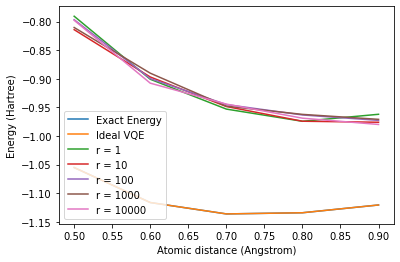

In [14]:
#taking average 
for b in range(len(energies)): 
    for d in range(len(energies[b])): 
        mean = np.mean(energies[b][d]) 
        energies[b][d] = mean
# plotting the data
plt.plot(distances, energies[0], label="Exact Energy")
plt.plot(distances, energies[0], label="Ideal VQE")

for b in range(n_boxes -2): 
    plt.plot(distances, energies[b+2], label="r = " + str(10**b))



plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

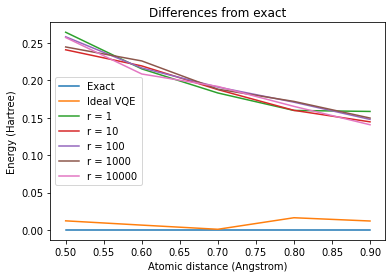

In [15]:
plt.plot(distances, [energies[0][i] - energies[0][i] for i in range(len(energies[0]))], label="Exact")
plt.plot(distances, [energies[1][i] - energies[0][i] for i in range(len(energies[0]))], label="Ideal VQE")

for b in range(n_boxes -2 ): 
    plt.plot(distances, [energies[b+2][i] - energies[0][i] for i in range(len(energies[0]))], label="r = " + str(10**b))



plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Differences from exact')
plt.legend()
plt.show()

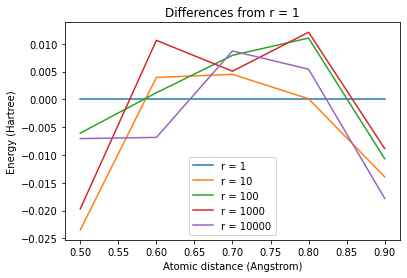

In [17]:
for b in range(5): 
    plt.plot(distances, [energies[b+2][i] - energies[2][i] for i in range(len(energies[0]))], label="r = " + str(10**b))



plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Differences from r = 1')
plt.legend()
plt.show()

In [77]:
param_circs = []
for circuit in ansatz_view: 
    i = 0
    for line in iter(circuit.splitlines()): 
        if "θ[7]" in line:
            i+=1
    print(i)

8
0
0


In [70]:
ansatz_view[0]

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,1.0*θ[0]) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,-1.0*θ[0]) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,-1.0*θ[1]) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-1.0*θ[1]) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,-pi/2,pi/2) q[2];\ncx q[2],q[3];\nu3(0,0,1.0*θ[2]) q[3];\ncx q[2],q[3];\nu3(-pi/2,-pi/2,pi/2) q[2];\nu3(pi/2,-pi/2,pi/2) q[2];\nu3(0,0,1.0*θ[2]) q[2];\nu3(-pi/2,-pi/2,pi/2) q[2];\nu3(pi/2,-pi/2,pi/2) q[2];\nu3(pi/2,0,pi) q[3];\ncx q[2],q[3];\nu3(0,0,1.0*θ[3]) q[3];\ncx q[2],q[3];\nu3(-pi/2,-pi/2,pi/2) q[2];\nu3(pi/2,0,pi) q[2];\nu3(pi/2,0,pi) q[3];\nu3(pi/2,-pi/2,pi/2) q[3];\ncx q[2],q[

# Analysis: 
The ansatz circuits may not have enough CNOTS and hence twirling  doesn't perform as well!